In [43]:
!pip -q install seaborn

In [ ]:
# 데이터 
# https://www.kaggle.com/competitions/talkingdata-adtracking-fraud-detection

In [44]:
import numpy as np 
import pandas as pd 
import datetime
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import gc
%matplotlib inline

In [45]:
#make wider graphs
sns.set(rc={'figure.figsize':(12,5)});
plt.figure(figsize=(12,5));

<Figure size 1200x500 with 0 Axes>

In [46]:
# 1 Deleting unused variables and gc.collect()¶

In [48]:
# eg:
#import some file
temp = pd.read_csv('train_sample.csv')

#do something to the file
temp['os'] = temp['os'].astype('str')

In [49]:
#delete when no longer needed
del temp
#collect residual garbage
gc.collect()

1979

In [51]:
# Presetting the datatypes

In [50]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        }

train = pd.read_csv('train_sample.csv', dtype=dtypes)

#check datatypes:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               100000 non-null  uint32
 1   app              100000 non-null  uint16
 2   device           100000 non-null  uint16
 3   os               100000 non-null  uint16
 4   channel          100000 non-null  uint16
 5   click_time       100000 non-null  object
 6   attributed_time  227 non-null     object
 7   is_attributed    100000 non-null  uint8 
dtypes: object(2), uint16(4), uint32(1), uint8(1)
memory usage: 2.8+ MB


In [52]:
# 3 Importing selected rows of a csv file

In [53]:
train = pd.read_csv('train_sample.csv', nrows=10000, dtype=dtypes)
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [54]:
train['click_time'] = pd.to_datetime(train['click_time'])
train['attributed_time'] = pd.to_datetime(train['attributed_time'])

In [55]:
train.describe(include='all')


/var/folders/2r/_fr309ls60x8zpqkcdvzvn940000gn/T/ipykernel_42420/2659650450.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  train.describe(include='all')
/var/folders/2r/_fr309ls60x8zpqkcdvzvn940000gn/T/ipykernel_42420/2659650450.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  train.describe(include='all')


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000,29,10000.000000
unique,NaN,NaN,NaN,NaN,NaN,9766,29,NaN
top,NaN,NaN,NaN,NaN,NaN,2017-11-07 02:24:37,2017-11-08 02:22:38,NaN
freq,NaN,NaN,NaN,NaN,NaN,3,1,NaN
first,NaN,NaN,NaN,NaN,NaN,2017-11-06 16:00:13,2017-11-07 01:19:12,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-11-09 15:58:36,2017-11-09 15:17:13,NaN
mean,91776.818600,12.103600,25.041900,23.195500,269.501100,NaN,NaN,0.002900
std,69458.137254,15.229093,281.241532,58.455354,130.016794,NaN,NaN,0.053776
min,9.000000,1.000000,0.000000,0.000000,3.000000,NaN,NaN,0.000000
25%,41848.500000,3.000000,1.000000,13.000000,140.000000,NaN,NaN,0.000000


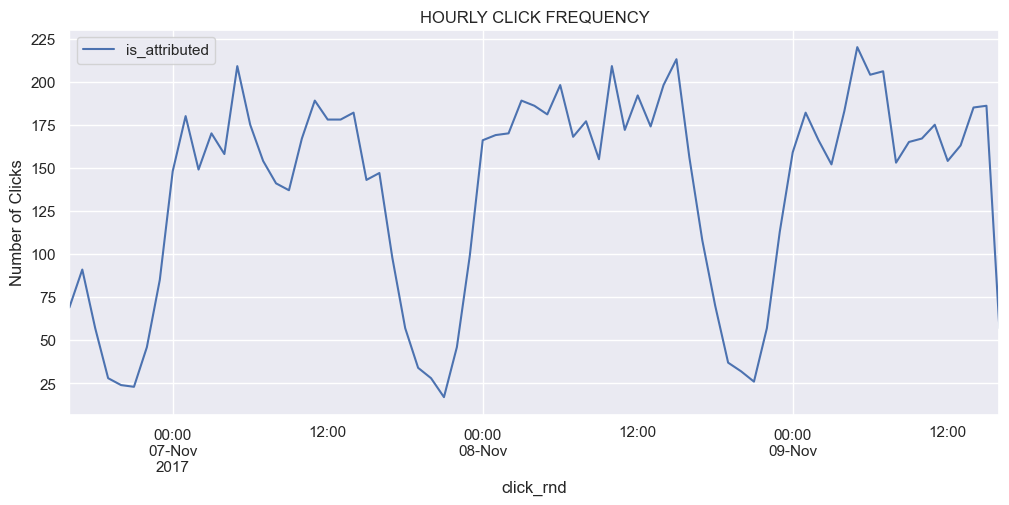

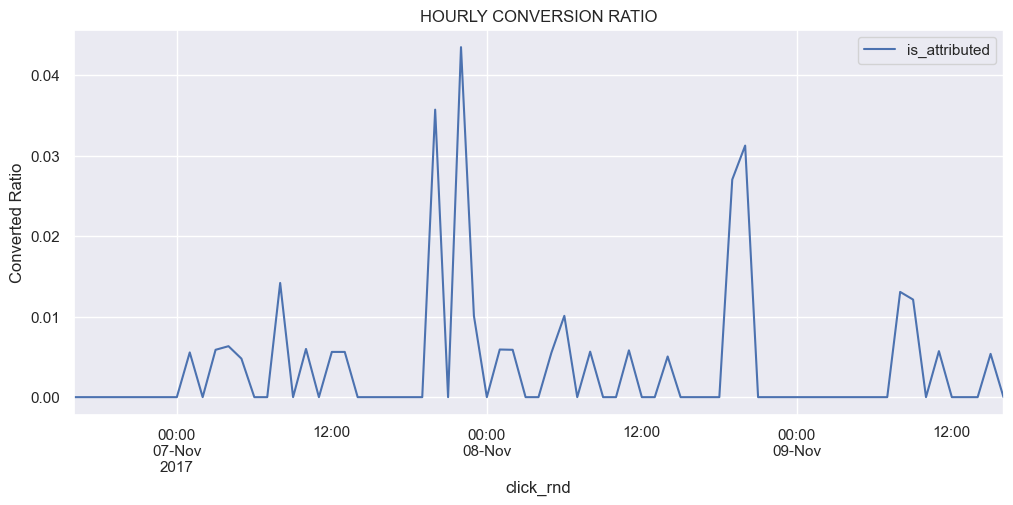

In [56]:
#round the time to nearest hour
train['click_rnd']=train['click_time'].dt.round('H')  

#check for hourly patterns
train[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).count().plot()
plt.title('HOURLY CLICK FREQUENCY');
plt.ylabel('Number of Clicks');

train[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).mean().plot()
plt.title('HOURLY CONVERSION RATIO');
plt.ylabel('Converted Ratio');

# 4 Importing in batches and processing each individually

In [69]:
#set up an empty dataframe
df_converted = pd.DataFrame()

#we are going to work with chunks of size 1 million rows
chunksize = 10 ** 4

#in each chunk, filter for values that have 'is_attributed'==1, and merge these values into one dataframe
for chunk in pd.read_csv('train_sample.csv', chunksize=chunksize, dtype=dtypes):
    print(len(chunk))
    filtered = (chunk[(np.where(chunk['is_attributed']==1, True, False))])
    df_converted = pd.concat([df_converted, filtered], ignore_index=True, )

10000
10000
10000
10000
10000
10000
10000
10000
10000
10000


# 5 Importing just selected columns

In [72]:
#wanted columns
columns = ['ip', 'click_time', 'is_attributed']
dtypes = {
        'ip'            : 'uint32',
        'is_attributed' : 'uint8',
        }

ips_df = pd.read_csv('train_sample.csv', usecols=columns, dtype=dtypes)

In [73]:
#processing part of the table is not a problem
ips_df[0:100][['ip', 'is_attributed']].groupby('ip', as_index=False).count()[:10]

,ip,is_attributed
0,2600,1
1,3488,1
2,4019,1
3,5314,2
4,5348,1
5,6414,1
6,7521,1
7,8362,1
8,9073,1
9,10831,1


In [74]:
size=1000
all_rows = len(ips_df)
num_parts = all_rows//size

#generate the first batch
ip_counts = ips_df[0:size][['ip', 'is_attributed']].groupby('ip', as_index=False).count()

#add remaining batches
for p in range(1,num_parts):
    start = p*size
    end = p*size + size
    if end < all_rows:
        group = ips_df[start:end][['ip', 'is_attributed']].groupby('ip', as_index=False).count()
    else:
        group = ips_df[start:][['ip', 'is_attributed']].groupby('ip', as_index=False).count()
    ip_counts = ip_counts.merge(group, on='ip', how='outer')
    ip_counts.columns = ['ip', 'count1','count2']
    ip_counts['counts'] = np.nansum((ip_counts['count1'], ip_counts['count2']), axis = 0)
    ip_counts.drop(columns=['count1', 'count2'], axis = 0, inplace=True)


In [76]:
ip_counts.sort_values('counts', ascending=False)[:20]


,ip,counts
27,5348,669.0
26,5314,616.0
410,73487,439.0
411,73516,399.0
314,53454,280.0
2388,114276,219.0
148,26995,218.0
553,95766,205.0
1011,17149,186.0
1465,100275,173.0


## conversion sum of ip

In [81]:
size=1000
all_rows = len(ips_df)
num_parts = all_rows//size

#generate the first batch
ip_sums = ips_df[0:size][['ip', 'is_attributed']].groupby('ip', as_index=False).sum()

#add remaining batches
for p in range(1,num_parts):
    start = p*size
    end = p*size + size
    if end < all_rows:
        group = ips_df[start:end][['ip', 'is_attributed']].groupby('ip', as_index=False).sum()
    else:
        group = ips_df[start:][['ip', 'is_attributed']].groupby('ip', as_index=False).sum()
    ip_sums = ip_sums.merge(group, on='ip', how='outer')
    ip_sums.columns = ['ip', 'sum1','sum2']
    ip_sums['conversions_per_ip'] = np.nansum((ip_sums['sum1'], ip_sums['sum2']), axis = 0)
    ip_sums.drop(columns=['sum1', 'sum2'], axis = 0, inplace=True)

In [83]:
#some cleanup
del ip_sums
del ips_df
del df_converted
del train
gc.collect()

2307

# DASK

In [84]:
import dask
import dask.dataframe as dd
from dask.distributed import Client

client = Client(thr)
client

In [86]:
dtypes = {'ip':'uint32',
          'app': 'uint16',
          'device': 'uint16',
          'os': 'uint16',
          'channel': 'uint16',
          'is_attributed': 'uint8'}

train = dd.read_csv("train_sample.csv", dtype=dtypes, parse_dates=['click_time', 'attributed_time'])
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0


In [89]:
#select only rows 'is_attributed'==1
train[train['is_attributed']==1].head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
284,224120,19,0,29,213,2017-11-08 02:22:13,2017-11-08 02:22:38,1
481,272894,10,1,7,113,2017-11-08 06:10:05,2017-11-08 06:10:37,1
1208,79001,19,0,0,213,2017-11-07 09:54:22,2017-11-07 11:59:05,1
1341,131029,19,0,0,343,2017-11-09 10:58:46,2017-11-09 11:52:01,1
1412,40352,19,0,0,213,2017-11-07 22:19:03,2017-11-08 01:55:02,1


In [90]:
#select only data attributed after 2017-11-06 
train[train['attributed_time']>='2017-11-07 00:00:00'].head()


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
284,224120,19,0,29,213,2017-11-08 02:22:13,2017-11-08 02:22:38,1
481,272894,10,1,7,113,2017-11-08 06:10:05,2017-11-08 06:10:37,1
1208,79001,19,0,0,213,2017-11-07 09:54:22,2017-11-07 11:59:05,1
1341,131029,19,0,0,343,2017-11-09 10:58:46,2017-11-09 11:52:01,1
1412,40352,19,0,0,213,2017-11-07 22:19:03,2017-11-08 01:55:02,1


In [91]:
ip_counts = train.ip.value_counts().compute()
ip_counts[:20]

/var/folders/2r/_fr309ls60x8zpqkcdvzvn940000gn/T/ipykernel_42420/1169736069.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ip_counts[:20]


5348      669
5314      616
73487     439
73516     399
53454     280
114276    219
26995     218
95766     205
17149     186
100275    173
105475    167
105560    149
111025    137
43793     135
86767     134
137052    128
5178      117
49602     116
48282     112
48170     112
Name: ip, dtype: int64

In [92]:
del ip_counts
gc.collect()

1018

In [93]:
channel_means = train[['channel','is_attributed']].groupby('channel').mean().compute()
channel_means[:20]

,is_attributed
channel,
3,0.004098
4,0.000000
5,0.714286
13,0.000000
15,0.000000
17,0.000000
18,0.000000
19,0.000000
21,0.105556


In [94]:
channel_means=channel_means.reset_index()
channel_means[:20]

,channel,is_attributed
0,3,0.004098
1,4,0.000000
2,5,0.714286
3,13,0.000000
4,15,0.000000
5,17,0.000000
6,18,0.000000
7,19,0.000000
8,21,0.105556
9,22,0.000000
